In [1]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
%matplotlib inline
import os
import help_functions as hf

# Code Purpose

From the raw read fastq data, cluster cells into different clones.

This code is adapted from the [LARRY preprocessing notebook by Caleb Weinreb](https://github.com/AllonKleinLab/LARRY/blob/master/clonal_annotation.ipynb)
There are some subtle difference in our handling of two source of errors in clonal annotation: 
    
    - Sequencing error
    - Clonal barcode dropout
    
In our notebook, the first error is controlled by setting the critical Hamming distance, and select the most abundant BC within each cluster as the representative BC.
The second error is controlled by setting a critical ratio of shared barcode among cells to be counted as from common clone.

To run this notebook, there should be a folder **Combined_T1T2** in the directory of this notebook, and the following 3 files should be in this folder
- **T1T2_cell_bcs_flat.txt**:   A list of cell barcodes, one barcode name for each cell
- **T1T2_samp_id_flat.txt**:   A list of sample id's, say *T1_HSC* or *T2_Kit*,  one id for each cell
- **T1T2_LARRY_sorted_and_filtered_barcodes.fastq.gz**:  A fastq file with raw reads, obtained from target sequencing at the clonal barcode regime 


## Set parameters

N_READS: Cutoff for the min number of reads supporting a given UMI/GFP-BC pair in a particular cell

N_UMIS: Cutoff for the min number of UMIs supporting a given cell/GFP-BC pair

N_HAMMING: Cutoff for the max hamming distance to collapse two GFP-BCs

CELL_BCS_PATH: Path to a .txt file with one cell-BC per line, corresponding to rows of the gene expression counts matrix

LIB_NAMES_PATH: Path to a .txt file with one library name per line, corresponding to rows of the gene expression counts matrix

dropout: Dropout probability of a clonal Barcode in the detection process.  


In [2]:
N_READS = 10
N_UMIS = 3  # these parameters might need to be changed.
N_HAMMING = 4  # originall 3
N_GOOD_BC=10; # the UMI threshold for unique clones
CELL_BCS_PATH = 'T1T2_cell_bcs_flat.txt'
LIB_NAMES_PATH = 'T1T2_samp_id_flat.txt'
not_plot_upper_right_line=1; # for plot setting
dropout=0; # barcode dropout rate, used for whether two cells with different set of barcodes
              # could be from the same clone due to dropout of BCs
              # In the main text of our paper, we used dropout=0 [no dropout correction]; 
        # In the supplemental material, we also used dropout=0.35 [with dropout correction]

## Read input file

In [3]:
mydir="./Combined_T1T2/"
data_dir_0=mydir+'Hamming_'+repr(N_HAMMING)+'/';
if dropout==0: data_dir=mydir+'Hamming_'+repr(N_HAMMING)+'/NoDropoutCorrection/';
else: data_dir=mydir+'Hamming_'+repr(N_HAMMING)+'/DropoutCorrection/';
fig_dir=mydir+'Hamming_'+repr(N_HAMMING)+'/figure/';

if not os.path.exists(mydir):
    !mkdir $mydir;
    
if not os.path.exists(data_dir_0):
    !mkdir $data_dir_0;
    
if not os.path.exists(data_dir):
    !mkdir $data_dir;
    
if not os.path.exists(fig_dir):
    !mkdir $fig_dir;

cell_bcs = open(mydir+CELL_BCS_PATH).read().strip('\n').split('\n')
lib_names = open(mydir+LIB_NAMES_PATH).read().strip('\n').split('\n')

In [4]:
data_dir

'./Combined_T1T2/Hamming_4/NoDropoutCorrection/'

## Load data and count reads

Read in the output of step 1 (LARRY_sorting_and_filtering.py) and count the number of reads supporting each (Sample, Cell-BC, UMI, GFP-BC) combination

In [5]:
counts = {}
f = gzip.open(mydir+'T1T2_LARRY_sorted_and_filtered_barcodes.fastq.gz')

# to get rid of the two artificial blank lines introduced in this particular concatenated file, run
# l = f.readline()
# l = f.readline()

# for other files that starts with a normal line, skip the above two lines and run directly: 
l = f.readline().decode("utf-8").strip('\n')

current_tag = []
i = 0
print('Reading in all barcodes')
while not (l == '' and len(current_tag)==0):
    #print(l)
    i += 1
    if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
    if l == '':
        current_tag = []
    elif l[0] == '>':
        current_tag = l[1:].split(',')
    elif l != '' and len(current_tag)==3:
        current_tag.append(l)
        current_tag = tuple(current_tag)
        if not current_tag in counts: counts[current_tag] = 0
        counts[current_tag] += 1
        
    l = f.readline().decode("utf-8").strip('\n')
    

Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Processed 10000000 reads
Processed 11000000 reads
Processed 12000000 reads
Processed 13000000 reads
Processed 14000000 reads
Processed 15000000 reads
Processed 16000000 reads
Processed 17000000 reads
Processed 18000000 reads
Processed 19000000 reads
Processed 20000000 reads
Processed 21000000 reads
Processed 22000000 reads
Processed 23000000 reads
Processed 24000000 reads
Processed 25000000 reads
Processed 26000000 reads
Processed 27000000 reads
Processed 28000000 reads
Processed 29000000 reads
Processed 30000000 reads
Processed 31000000 reads
Processed 32000000 reads
Processed 33000000 reads


## Filter by number of reads
Continue with analysis with (Sample, Cell-BC, UMI, GFP-BC) combinations supported by at least N_READS reads

Retaining 509880 out of 3129186 (Sample,Cell-BC,UMI,GFP-BC) combinations


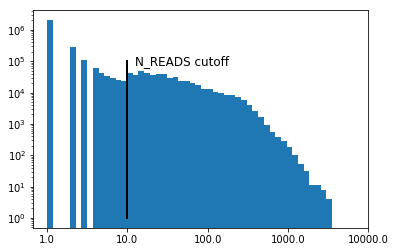

In [6]:
num_reads = [v for k,v in counts.items()]
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.plot([np.log(N_READS)/np.log(10),np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(5),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

In [7]:
num_reads = [v for k,v in counts.items()]
print("Total Reads ",sum(num_reads))

Total Reads  33062765


In [8]:
# all UMIs, some of them are the same (from the same BCs), some are different
umi_list=[k[3] for k in counts_filtered]
print(umi_list[0:3])
print("Total UMI ",len(umi_list))

['AAATTGAAGCCACGCAACGAAAGAAATTG', 'GGAGTGTGCGCACGGAACGCCCGAATGTG', 'AAATTGAAGCCACGCAACGAAAGAAATTG']
Total UMI  509880


## Collapse GFP-BCs by hamming distance

The general strategy: First identify BCs with at least certain number of UMI as the proper clones. This makes sure that we at least get the large clones right, which is far more important. Use them to cluster the remainin BCs with a certain distance. If some BCs still cannot be clustered, pick them as new clones and do clustering again

Compute the frequency for each unique BCs, to be used later

In [9]:


all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
#N_HAMMING = 3  # originall 3

save_file_name=data_dir+"all_gfp_bcs_count_Hamm_"+repr(N_HAMMING)+".npy";

if not os.path.exists(save_file_name):
    all_gfp_bcs_count_1=np.zeros(len(all_gfp_bcs));  # this is still just UMI
    for j,bc1 in enumerate(all_gfp_bcs):
        for k in counts_filtered:
            if bc1==k[3]:
                all_gfp_bcs_count_1[j]=all_gfp_bcs_count_1[j]+1;
    
    all_gfp_bcs_count=np.array(all_gfp_bcs_count_1,dtype='int');
    np.save(save_file_name,all_gfp_bcs_count);
    
else:
    all_gfp_bcs_count=np.load(save_file_name);
    

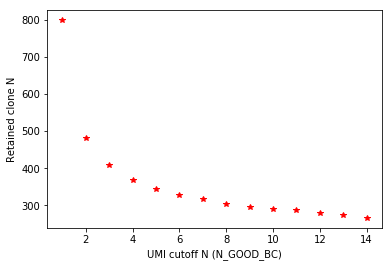

In [10]:
# The number of unique clones as a function of UMI cutoffs.  
# A clone with large number of UMI is more likely to be a true clone

threshold=np.array(range(1,15));
BC_N_UMI_threshold=np.zeros(len(threshold),dtype='int');
for j in range(len(threshold)):
    BC_N_UMI_threshold[j]=sum(all_gfp_bcs_count>=threshold[j]);
    
                      
plt.plot(threshold,BC_N_UMI_threshold,'*r')   
plt.xlabel("UMI cutoff N (N_GOOD_BC)")
plt.ylabel("Retained clone N");


Initialize a map where each valid BC is separated by a minimum Hamming distance.  The map itself may be sensitive to the order of going through all the barcode list

In [11]:

def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

#initialize the unique clone list with clones of at least 6 UMI
# good_gfp_bcs = np.array(all_gfp_bcs)[all_gfp_bcs_count>=N_GOOD_BC]
# good_gfp_bcs=list(good_gfp_bcs) 


good_gfp_bcs=[];
bc_map = {} # all_BC mapped to good BCs.
for i,bc1 in enumerate(all_gfp_bcs):
#    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2 
            break
    if not mapped:
        good_gfp_bcs.append(bc1) # expand the list of clones

for bc in good_gfp_bcs: bc_map[bc] = bc #also incorporate the reference bc itself
    
print("The actual distinct BC (after denoising) number is "+repr(len(good_gfp_bcs)))

The actual distinct BC (after denoising) number is 321


Generate a new map using the most abundant BC as the representative.  The abundant BC is selected from each of the BC cluster identified in the previous step.

In [12]:


bc_map_new={}; # the new map
good_gfp_bcs_new=[]; # the new representative
tot_count_array=np.zeros(len(good_gfp_bcs));
true_count_array=np.zeros(len(good_gfp_bcs));
for k,bc in enumerate(good_gfp_bcs):
    print("\nnew\n")
    max_index=-1;
    max_count=0;
    tot_count=0;
    for j,bc1 in enumerate(all_gfp_bcs):
        if bc_map[bc1]==bc:
            print("UMI",all_gfp_bcs_count[j],"\td",hamming(bc,bc1))
            print(bc1)
            tot_count+=all_gfp_bcs_count[j];
            if max_count<all_gfp_bcs_count[j]:
                max_index=j;
                max_count=all_gfp_bcs_count[max_index]
                
                
    tot_count_array[k]=tot_count;
    true_count_array[k]=all_gfp_bcs_count[max_index];
    print("Authentic fraction is ",all_gfp_bcs_count[max_index]/tot_count)
    good_gfp_bcs_new.append(all_gfp_bcs[max_index]);
    
    for j,bc1 in enumerate(all_gfp_bcs):
        if bc_map[bc1]==bc:
            bc_map_new[bc1]=all_gfp_bcs[max_index];
            
    
    


new

UMI 9 	d 0
AAAATGAAAACAAACGACACATGATCCTG
UMI 9 	d 2
AAAATGAAAACAGACAACACATGATCCTG
UMI 1 	d 2
AAAATGAAAACAGACGACAAATGATCCTG
UMI 1 	d 2
AAAATGAAAACAGACGACACACGATCCTG
UMI 1 	d 2
AAAATGAAAACAGACGACACAGGATCCTG
UMI 2 	d 2
AAAATGAAAACAGACGACACATGACCCTG
UMI 1 	d 2
AAAATGAAAACAGACGACACATGAGCCTG
UMI 1 	d 2
AAAATGAAAACAGACGACACATGATCATG
UMI 1 	d 2
AAAATGAAAACAGACGACACATGATCCCG
UMI 90901 	d 1
AAAATGAAAACAGACGACACATGATCCTG
UMI 3 	d 2
AAAATGAAAACAGACGACACATGATCTTG
UMI 4 	d 2
AAAATGAAAACAGACGACACGTGATCCTG
UMI 3 	d 2
AAAATGAAAACAGACGACATATGATCCTG
UMI 4 	d 2
AAAATGAAAACAGACGACGCATGATCCTG
UMI 1 	d 2
AAAATGAAAACAGTCGACACATGATCCTG
UMI 3 	d 2
AAAATGAAACCAGACGACACATGATCCTG
UMI 2 	d 2
AAAATGAAAGCAGACGACACATGATCCTG
UMI 3 	d 2
AAAATGAAGACAGACGACACATGATCCTG
UMI 1 	d 2
AAAATGAGAACAGACGACACATGATCCTG
UMI 2 	d 2
AAAATGGAAACAGACGACACATGATCCTG
UMI 1 	d 2
AAATTGAAAACAGACGACACATGATCCTG
UMI 3 	d 2
AAGATGAAAACAGACGACACATGATCCTG
UMI 11 	d 2
GAAATGAAAACAGACGACACATGATCCTG
Authentic fraction is  0.9992634772667311

new

CCGTTGTTTGCACCGGACTTGGGACGAAG
UMI 2 	d 2
CCGTTGTTTGCACTGGACCTGGGACGAAG
Authentic fraction is  0.9946692991115499

new

UMI 81 	d 0
CCCATGATCACAGTATACGGTTGAACCGG
Authentic fraction is  1.0

new

UMI 1 	d 0
CCCATGCACACAGGGCACCAACGATAACG
UMI 2 	d 2
CCCATGCACGCACGGCACCAACGATAACG
UMI 4 	d 2
CCCATGCACGCAGGGCACCAACGAAAACG
UMI 1457 	d 1
CCCATGCACGCAGGGCACCAACGATAACG
UMI 11 	d 2
GCCATGCACGCAGGGCACCAACGATAACG
Authentic fraction is  0.9877966101694915

new

UMI 19 	d 0
CCCCTGCCCGCACGTTACCTCTGACATTG
Authentic fraction is  1.0

new

UMI 45 	d 0
CCCCTGCTCCCAGGTCACTCGTGAGATCG
Authentic fraction is  1.0

new

UMI 18 	d 0
CCCCTGGCCCCAGACCACCACCGACGGTG
Authentic fraction is  1.0

new

UMI 13 	d 0
CCCGTGCCGCCAGTGTACAGAGGATACTG
Authentic fraction is  1.0

new

UMI 1 	d 0
CCCTTGAGATCACCTAACAACTGAGGAAG
UMI 321 	d 1
CCTTTGAGATCACCTAACAACTGAGGAAG
Authentic fraction is  0.9968944099378882

new

UMI 5 	d 0
CCCTTGCCCTCACCGGACCTCGGACGACG
Authentic fraction is  1.0

new

UMI 1 	d 0
CCCTTGTCCCCACGCGACATCGGAACTGG
UM

UMI 1 	d 0
TTGCTGCAGTCAGACAACTTATGAACAAG
UMI 10 	d 1
TTGCTGCAGTCAGACAACTTATGAACAGG
Authentic fraction is  0.9090909090909091

new

UMI 1 	d 0
TTGGTGCGCCCATGTAACACATGAACCCG
UMI 275 	d 1
TTGGTGCGCCCATGTAACGCATGAACCCG
Authentic fraction is  0.9963768115942029

new

UMI 5 	d 0
TTGTTGAGGCCAGGTCACAATTGACAGGG
Authentic fraction is  1.0

new

UMI 3292 	d 0
TTTATGAAAACATGTCACGACAGAATAAG
Authentic fraction is  1.0

new

UMI 9 	d 0
TTTATGCGACCACACAACGACAGACGGCG
Authentic fraction is  1.0


In [13]:
print("The single-point sequencing error for a 29bp BC is ",1-sum(true_count_array)/sum(tot_count_array))
print("Total UMI is ",sum(tot_count_array))

The single-point sequencing error for a 29bp BC is  0.0035361261473287886
Total UMI is  509880.0


In [14]:
# histogram of the Hamming distance between these unique clones [not that the abundance for each clone is not considered]

tot_BC=len(all_gfp_bcs);
dis_all=np.zeros(int(tot_BC*(tot_BC-1)/2));
count=0;
for i,bc1 in enumerate(all_gfp_bcs):
    for j in range(i+1,tot_BC):
            bc2=all_gfp_bcs[j];
            if bc2!=bc1:
                dis_all[count]=hamming(bc1,bc2);
                count +=1;
dis_all=dis_all[0:count];

# distance relative to the old BC representative, still does not explicit consider the weight for each unique BC

dis_random_BC=np.zeros(int(tot_BC*len(good_gfp_bcs)));
count=0;
for i,bc1 in enumerate(good_gfp_bcs):
    for j in range(tot_BC):
            bc2=all_gfp_bcs[j];
            if bc2!=bc1:
                dis_random_BC[count]=hamming(bc1,bc2);
                count +=1;
dis_random_BC=dis_random_BC[0:count];

# distance relative to the most abundant BCs, still does not explicit consider the weight for each unique BC


dis_abundant_BC=np.zeros(int(tot_BC*len(good_gfp_bcs)));
count=0;
for i,bc1 in enumerate(good_gfp_bcs_new):
    for j in range(tot_BC):
            bc2=all_gfp_bcs[j];
            if bc2!=bc1:
                dis_abundant_BC[count]=hamming(bc1,bc2);
                count +=1;
dis_abundant_BC=dis_abundant_BC[0:count]

Average distance between clonall BC and other BC within the clone (Random clonal BC-1): 1.9375232428412048
Average distance between clonall BC and other BC within the clone (Random clonal BC-2 Caleb): 1.8723849372384938
Average distance between clonall BC and other BC within the clone (Abundant clonal BC): 1.0732217573221758


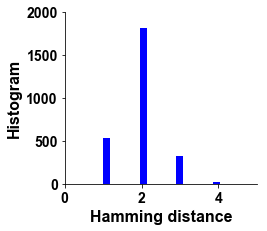

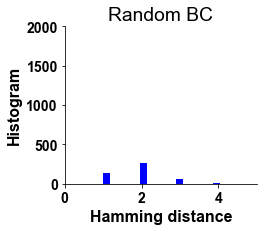

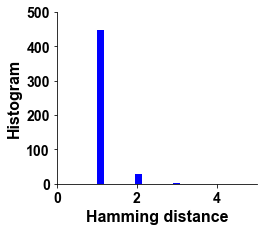

In [15]:
%run my_fig_config
ax.hist(dis_all,100,color="blue");
plt.xlim([0,5])
plt.ylim([0,2000])
ax.set_xlabel("Hamming distance")
ax.set_ylabel("Histogram")
#ax.set_yscale('log')
if not_plot_upper_right_line:
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
fig.tight_layout();
fig.savefig(fig_dir+"histogram_hamming_distance_1.eps")
x=dis_all[dis_all<=5];
print("Average distance between clonall BC and other BC within the clone (Random clonal BC-1):", np.mean(x))

# %run my_fig_config
# ax.hist(dis_all,100,color="blue");
# plt.xlim([0,10])
# #plt.ylim([0,2000])
# ax.set_yscale('log')
# ax.set_xlabel("Hamming distance")
# ax.set_ylabel("Histogram")
# if not_plot_upper_right_line:
#         ax.spines['right'].set_color('none')
#         ax.spines['top'].set_color('none')
# fig.tight_layout();
# fig.savefig(fig_dir+"histogram_hamming_distance_1.eps")

            
%run my_fig_config
ax.hist(dis_random_BC,100,color="blue");
plt.xlim([0,5])
plt.ylim([0,2000])
#ax.set_yscale('log')
ax.set_xlabel("Hamming distance")
ax.set_ylabel("Histogram")
ax.set_title("Random BC")
if not_plot_upper_right_line:
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
fig.tight_layout();
fig.savefig(fig_dir+"histogram_hamming_distance_2.eps")
x=dis_random_BC[dis_random_BC<=5];
print("Average distance between clonall BC and other BC within the clone (Random clonal BC-2 Caleb):", np.mean(x))

%run my_fig_config
ax.hist(dis_abundant_BC,100,color="blue");
plt.xlim([0,5])
plt.ylim([0,500])
#ax.set_yscale('log')
ax.set_xlabel("Hamming distance")
#ax.set_title("Most Abundant BC")
ax.set_ylabel("Histogram")
if not_plot_upper_right_line:
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
fig.tight_layout();
fig.savefig(fig_dir+"histogram_hamming_distance_3.eps")
x=dis_abundant_BC[dis_abundant_BC<=5];
print("Average distance between clonall BC and other BC within the clone (Abundant clonal BC):", np.mean(x))

In [16]:
# replacde old map with the new one
bc_map=bc_map_new;
good_gfp_bcs=good_gfp_bcs_new;

## Filter GFP-barcodes by UMI
Index (UMI, GFP-BC) combinations to cells, then filter out BCs supported by fewer than N_UMIS UMIs.  At this stage, each cell may have several BCs due to multiple lentiviral integration

The output of this step is final_BCs, a list that has the BCs for each cell


Final annotation has 485 clones in 26252 cells


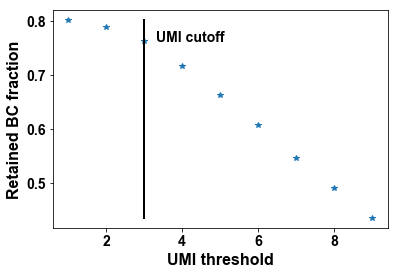

In [17]:
# It is a dictionary within a dictionary
# a dictionary of {"(libary name, cell_BC)":{"clone barcode": UMI}}
# note that the same libary-cell combination can have multiple clone BCs because a single cell can be infected 
# by many virus at the same time.
# N_UMIS=3;
cell_data = {}


# Initialize the dictionary
# zip combines two lists so that they can be accessed using the same index
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0 #initialize the UMI of specific BC in a library-cell combination
        cell_data[(lib,cell)][BC] += 1 # counting the UMI of BC

        
## generate a list of valid cell barcode with different UMI threshold i for each cell       
BC_lists = [] 
for UMI_cutoff in range(1,10):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)] # bc_counts is a dictionary, EACH cell has several BCs
        valid_bcs = [bc_map[bc] for bc,bc_UMI in bc_counts.items() if bc_UMI >= UMI_cutoff]# replace the BC with the reference BC 
        valid_bcs=list(set(valid_bcs)); # it is possible that two BCs in the cell derived from the same one, but becomes different due to sequencing.  We correct the redundancy here.
        BC_list.append('_'.join(sorted(valid_bcs))) #join the BC for form a complete identify of the clone
    BC_lists.append(BC_list)

# determine the threshold based on the histogram plot   
# count the fraction of retained bcs at a given cutoff UMI
efficiency = np.array([len([bc for bc in bc_list_given_umi if len(bc)>0]) for bc_list_given_umi in BC_lists]) / len(cell_bcs)
plt.plot(range(1,10),efficiency,"*")
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)
plt.xlabel("UMI threshold")
plt.ylabel("Retained BC fraction")

# picking the correct list of cell barcode
final_BCs = BC_lists[N_UMIS-1]
total_N=sum([1 for x in list(set(final_BCs)) if len(x)>0]);
print('\nFinal annotation has '+repr(total_N)+' clones in '+repr(len([l for l in final_BCs if len(l)>0]))+' cells')

Generate a clone_mat, a binary matrix where rows are cells and columns are clones

In [18]:
# final_BCs is a list of the BCs for each cell
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
clone_vec = clone_mat.sum(0);

In [19]:
good_gfp_bc_sets=[];
bc_set_map = {} # all_BC mapped to good BCs.
bc_len_vec=np.zeros(len(BC_set));
print("---------------------------")
for k,bc1 in enumerate(BC_set):
#    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    bc_len_vec[k]=round(len(bc1)/29);
    for j,bc2 in enumerate(good_gfp_bc_sets):
        if hf.match_or_not_1(bc1,bc2,N_HAMMING,dropout):
            mapped = True
            bc_set_map[bc1] = bc2
            print("mapped clone size",clone_vec[k],"BC len:",bc_len_vec[k])
            break
    if not mapped:
        good_gfp_bc_sets.append(bc1) # expand the list of clones

for bc in good_gfp_bc_sets: bc_set_map[bc] = bc #also incorporate the reference bc itself




---------------------------


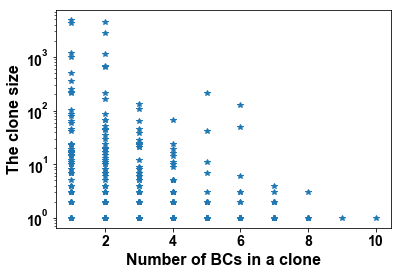

In [20]:
# the very large bc set could be due to doublets
plt.plot(bc_len_vec,clone_vec,'*')
plt.xlabel("Number of BCs in a clone")
plt.ylabel("The clone size")
plt.yscale('log')

Generate a new map using the most abundant BC_list as the representative within each cluster of the clone, 
where a clone is defined to be cells with similar BC list

In [21]:


bc_set_map_new={}; # the new map
good_gfp_bc_sets_new=[]; # the new representative
tot_count_set_array=np.zeros(len(good_gfp_bc_sets));
true_count_set_array=np.zeros(len(good_gfp_bc_sets));
for k,bc in enumerate(good_gfp_bc_sets):
    print("---------------")
    max_index=-1;
    max_count=0;
    tot_count=0;
    for j,bc1 in enumerate(BC_set):
        if bc_set_map[bc1]==bc:
            print("clone size",clone_vec[j],"; BC len",round(len(bc1)/29),"; No. matched BC: ",hf.match_N(bc,bc1,N_HAMMING))
            tot_count+=clone_vec[j];
            if max_count<clone_vec[j]:
                max_index=j;
                max_count=clone_vec[max_index]
                
                
    tot_count_set_array[k]=tot_count;
    true_count_set_array[k]=clone_vec[max_index];
    print("Authentic fraction is ",clone_vec[max_index]/tot_count)
    good_gfp_bc_sets_new.append(BC_set[max_index]);
    
    for j,bc1 in enumerate(BC_set):
        if bc_set_map[bc1]==bc:
            bc_set_map_new[bc1]=BC_set[max_index];
            

            

---------------
clone size 4285 ; BC len 1 ; No. matched BC:  1
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 6 ; No. matched BC:  6
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 7 ; No. matched BC:  7
Authentic fraction is  1.0
---------------
clone size 2 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 6 ; No. matched BC:  6
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 8 ; No. matched BC:  8
Authentic fraction is  1.0
---------------
clone size 46 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 7 ; No. matched BC:  7
Authentic fraction is  1.0
---------------
clone size 1

Authentic fraction is  1.0
---------------
clone size 11 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 7 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 2 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 2 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 2 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 3 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 20 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 21 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
--

---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 2 ; BC len 1 ; No. matched BC:  1
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 4 ; No. matched BC:  4
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 35 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 63 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 4 ; No. matched BC:  4
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 3 ; No. matched BC:  3
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 1 ; BC len 2 ; No. matched BC:  2
Authentic fraction is  1.0
---------------
clone size 355 ; BC len 1 ; No. matched BC:  1
Authentic fraction is  1.0
---------------
clone size 1

In [22]:
## update the BCs representation for each cell
for j, bc in enumerate(final_BCs):
    if bc!='':
        final_BCs[j]=bc_set_map_new[bc];
    
print("Total (final) clone number is "+repr(len(good_gfp_bc_sets)))

Total (final) clone number is 485


# Split the T1T2 combined data into T1 and T2 separately

In [23]:
# T1
T1_cell_N=8799; #external parameter

T1_BC_set=[];
for j in range(T1_cell_N):
    if (final_BCs[j] not in T1_BC_set) and final_BCs[j]!="":
        T1_BC_set.append(final_BCs[j]);
        
#T1_BC_set = sorted(set([bc for bc in T1_BC_set if bc != '']))
T1_final_BCs=final_BCs[:T1_cell_N];

# T2
T2_BC_set=[];
for j in range(T1_cell_N,len(final_BCs)):
    if (final_BCs[j] not in T2_BC_set) and final_BCs[j]!="":
        T2_BC_set.append(final_BCs[j]);
        
#T2_BC_set = sorted(set([bc for bc in T2_BC_set if bc != '']))
T2_final_BCs=final_BCs[T1_cell_N:];

In [24]:
len(T2_final_BCs)

25636

## Outout clonal anotations
For each dataset (T1,T2,or a combined data with both T1 and T2), there are three output files: 
- clone_mat.csv
- clone_mat.npy
- barcode_list.txt
- BC_sequence.txt


The two clone_mat files store a binary matrix where rows are cells and columns are clones. A "1" at entry (i,j) indicates that cell i belongs to clone j. The barcode_list file stores the barcode for each cell. Two barcode strings separated by an underscore indicates that the cell contains multiple barcodes. An empty line implies no barcode for that cell. Finally, BC_sequence.txt gives the set of clone barcodes. 

In [25]:
## T1+T2
#data_dir=mydir+'Hamming_'+repr(N_HAMMING)+'/'
#if not os.path.exists(data_dir):
#    %mkdir $data_dir
    

BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
np.savetxt(data_dir+'T1T2_clone_mat.csv',clone_mat,delimiter=',',fmt='%i');
np.save(data_dir+'T1T2_clone_mat.npy',clone_mat);
open(data_dir+'T1T2_barcode_list.txt','w').write('\n'.join(final_BCs));
open(data_dir+'T1T2_BC_sequence.txt','w').write('\n'.join(BC_set));

In [26]:
## T1

T1_clone_mat = np.zeros((len(T1_final_BCs),len(T1_BC_set)))
for i,bc in enumerate(T1_final_BCs):
    if bc != '':
        j = T1_BC_set.index(bc)
        T1_clone_mat[i,j] = 1
T1_clone_mat = np.array(T1_clone_mat,dtype=int)
np.savetxt(data_dir+'T1_clone_mat.csv',T1_clone_mat,delimiter=',',fmt='%i');
np.save(data_dir+'T1_clone_mat.npy',T1_clone_mat);
open(data_dir+'T1_barcode_list.txt','w').write('\n'.join(T1_final_BCs));
open(data_dir+'T1_BC_sequence.txt','w').write('\n'.join(T1_BC_set));

In [27]:
## T2

T2_clone_mat = np.zeros((len(T2_final_BCs),len(T2_BC_set)))
for i,bc in enumerate(T2_final_BCs):
    if bc != '':
        j = T2_BC_set.index(bc)
        T2_clone_mat[i,j] = 1
T2_clone_mat = np.array(T2_clone_mat,dtype=int)
np.savetxt(data_dir+'T2_clone_mat.csv',T2_clone_mat,delimiter=',',fmt='%i');
np.save(data_dir+'T2_clone_mat.npy',T2_clone_mat);
open(data_dir+'T2_barcode_list.txt','w').write('\n'.join(T2_final_BCs));
open(data_dir+'T2_BC_sequence.txt','w').write('\n'.join(T2_BC_set));

In [28]:
print("Number of T1 clones",len(T1_BC_set))
print("Number of T2 clones",len(T2_BC_set))

Number of T1 clones 414
Number of T2 clones 133


In [29]:
len(BC_set)

485